# Extract 1D Spectra From SOSS Observations

After time-series observations are taken in NIRISS SOSS mode, the data can be cleaned and calibrated using the JWST pipeline. 

We will NOT cover that step in this notebook but will instead begin with some data that mimicks the calibrated output of the JWST pipeline.

Let's begin with some imports...

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from astropy.io import fits
from matplotlib.colors import LogNorm
from soss_jetspec import niriss_soss
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Take a look at the observations

First we'll open the provided file, grab the 2D data and take a look at the header.

In [7]:
filename = 'niriss_soss_gj436_exposure_signal.fits'
data2D = fits.getdata(filename)
fits.getheader(filename)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2017-03-03T11:30:25.982' / Date this file was created (UTC)          
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
FILENAME= 'niriss_uncal_soss_gj436_exposure_dq_init_saturation_ipc_superbias_l&'
CONTINUE  'inearity_dark_current_rateints.fits&'                                
CONTINUE  '' / Name of the file                                                 
FILETYPE= 'uncalibrated'       / Type of data in the file                       
SDP_VER = '2016_1  '           / Data processing software version number        
PRD_VER = 'PRDDEVSOC-D-012' 

Notice the shape of the data is `(900, 256, 2048)` since the reduced data are comprised of 900 integrations of the SOSS SUBSTRIP256 subarray, which is 256 rows and 2048 columns. Let's take a glance at one of the integrations.

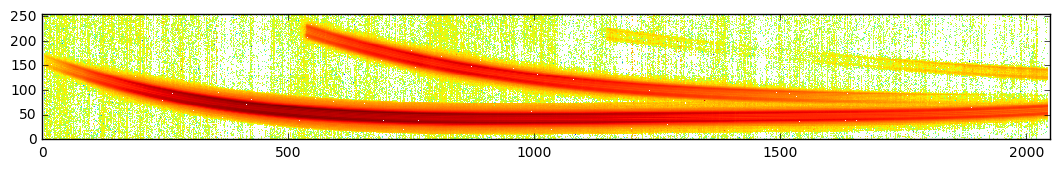

In [11]:
plt.figure(figsize=(13,2))
plt.imshow(data2D[0][:,::-1], interpolation='none', norm=LogNorm(), origin='lower')

## Run the spectral extraction on the 2D data

What we would like from these data are an array of 900 1-D spectra along with their associated Julian Days. Then we can fit lightcurves to the spectra to find our planet.

The JWST pipeline assigns an average wavelength to each of the 2048 columns of the SOSS subarray and then performs a simple column sum extraction routine, but we will demonstrate a more robust technique here that isolates the trace to exclude background pixels.

Processing data frames...
Total # of integrations: 333
1

/Users/jfilippazzo/Documents/Modules/NIRISS/soss_jetspec/optspex.py:345: RuntimeWarning: invalid value encountered in true_divide
  profile /= np.sum(profile, axis=0)


333

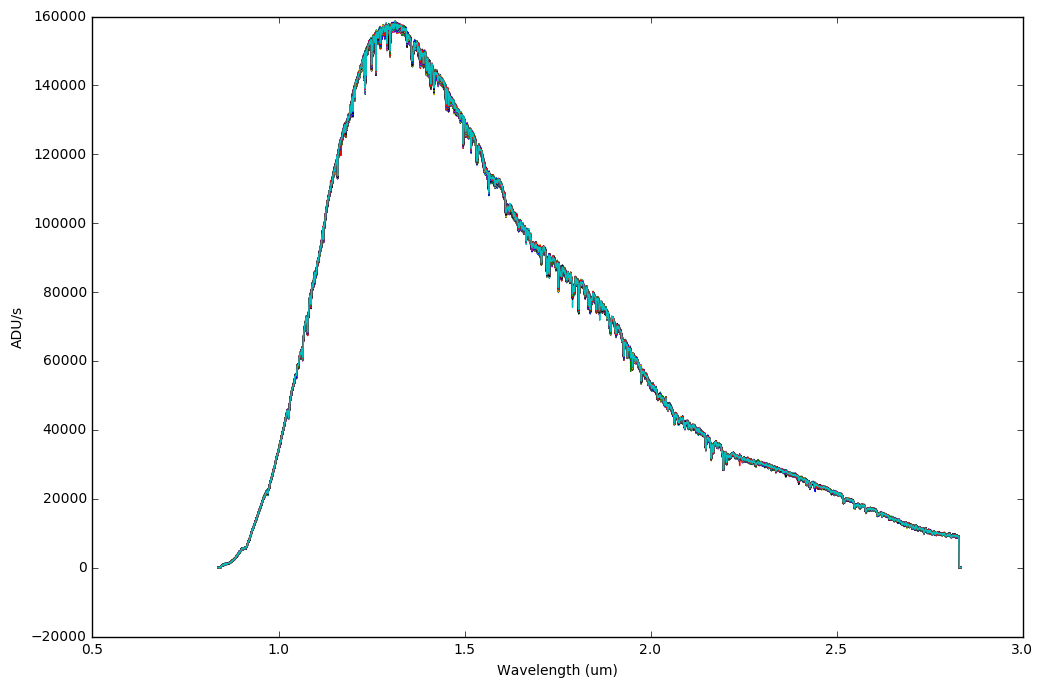

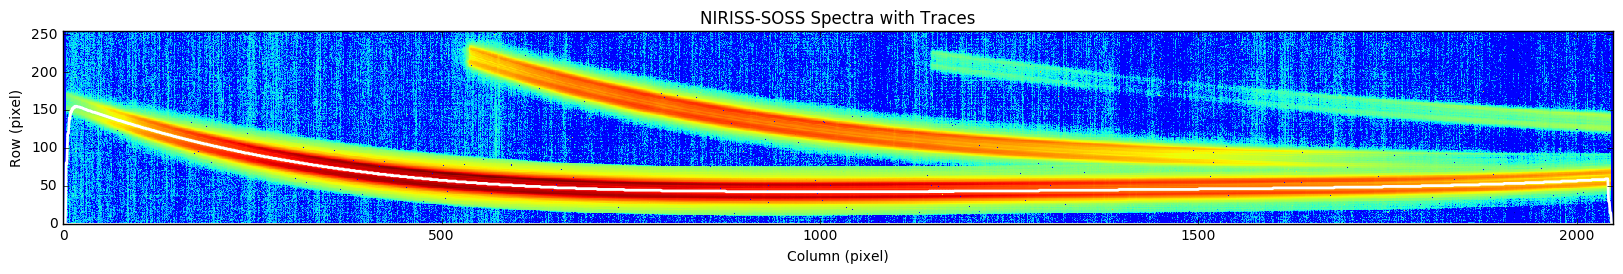

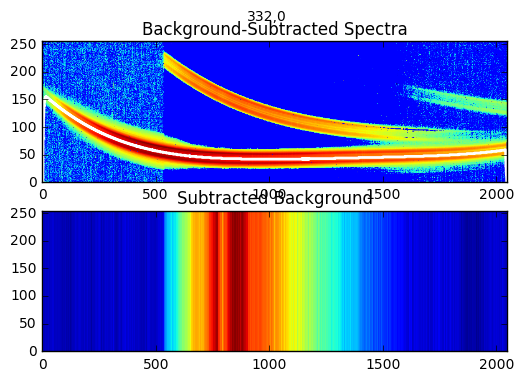

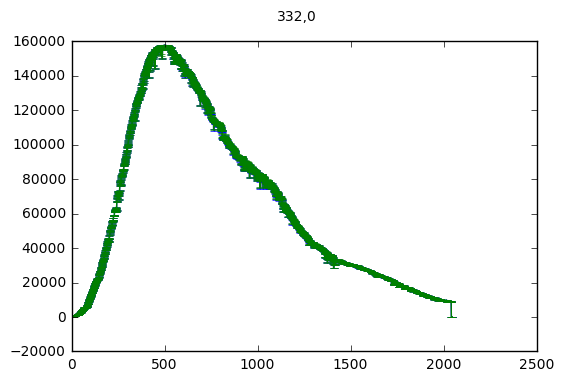

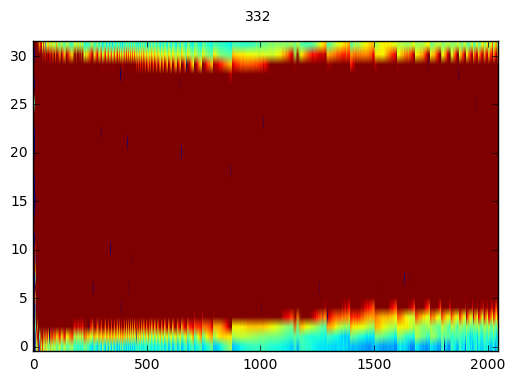

In [12]:
data1D = niriss_soss.spectrum_extract(filename, norders=1, isplots=3)

Check your desktop for the saved file of extracted 1D spectra!